In [10]:
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os
from itertools import combinations


In [14]:
# 1. Definir índices de trastornos

NUM_PREGUNTAS = 25 
NUM_TRASTORNOS = 5
PREGUNTAS_POR_TRASTORNO = 5

# Nombres de las clases para referencia
clases = [
    'Trastorno Depresivo Mayor',
    'Trastorno de Ansiedad Generalizada',
    'Trastorno de Ansiedad Social',
    'Trastorno por Déficit de Atención',
    'Trastorno Antisocial de la Personalidad'
]
# Definir los índices correspondientes a las preguntas de cada trastorno
indices_trastornos = [
    range(0, 5),   # Preguntas para Trastorno Depresivo Mayor
    range(5, 10),  # Preguntas para Trastorno de Ansiedad Generalizada
    range(10, 15), # Preguntas para Trastorno de Ansiedad Social
    range(15, 20), # Preguntas para Trastorno por Déficit de Atención
    range(20, 25)  # Preguntas para Trastorno Antisocial de la Personalidad
]

max_val = PREGUNTAS_POR_TRASTORNO * 4  # Valor máximo por trastorno


In [29]:
def calcular_etiquetas(X):
    """
    Calcula las etiquetas (Y) basándose en las respuestas (X).
    """
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    for i, indices in enumerate(indices_trastornos):
        suma = np.sum(X[indices])
        porcentaje = suma / max_val
        Y[i] = round(porcentaje, 3)
    return Y

def generar_caso_unico_trastorno(trastorno_id):
    """
    Genera un caso con un solo trastorno específico.
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    X[indices_trastornos[trastorno_id]] = 4  # Respuestas altas solo en el trastorno específico
    Y = calcular_etiquetas(X)  # Calcular etiquetas basadas en las respuestas generadas
    return X, Y

def generar_caso_multiple_trastornos(trastorno_ids):
    """
    Genera un caso con múltiples trastornos.
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    for trastorno_id in trastorno_ids:
        X[indices_trastornos[trastorno_id]] = 4  # Asignar respuestas altas en varios trastornos
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_unico_trastorno_con_ruido(trastorno_id, ruido_min=0, ruido_max=3):
    """
    Genera un caso con un solo trastorno y ruido en las demás respuestas.
    """
    X = np.random.randint(ruido_min, ruido_max + 1, size=NUM_PREGUNTAS)
    X[indices_trastornos[trastorno_id]] = 4  # Respuestas altas en el trastorno específico
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_multiple_trastornos_con_ruido(trastorno_ids, ruido_min=0, ruido_max=3):
    """
    Genera un caso con múltiples trastornos y ruido en las demás respuestas.
    """
    X = np.random.randint(ruido_min, ruido_max + 1, size=NUM_PREGUNTAS)
    for trastorno_id in trastorno_ids:
        X[indices_trastornos[trastorno_id]] = 4  # Respuestas altas en múltiples trastornos
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_mixto_sin_trastornos(ruido_min=0, ruido_max=3):
    """
    Genera un caso mixto sin trastornos predominantes, con ruido.
    """
    X = np.random.randint(ruido_min, ruido_max + 1, size=NUM_PREGUNTAS)
    # Añadir una pequeña probabilidad de respuestas altas
    prob_4 = 0.05
    high_score_indices = np.random.rand(NUM_PREGUNTAS) < prob_4
    X[high_score_indices] = 4
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_uniforme(valor):
    """
    Genera un caso donde todas las respuestas en X tienen el mismo valor.
    """
    X = np.full(NUM_PREGUNTAS, valor, dtype=int)
    Y = calcular_etiquetas(X)
    return X, Y

def generar_conjunto_de_datos():
    """
    Genera un conjunto de datos balanceado con diferentes tipos de casos, incluyendo casos uniformes.
    """
    X_list = []
    Y_list = []
    X_set = set()  # Para evitar duplicados

    # Definir número de muestras para cada tipo de caso
    muestras_por_tipo = {
        'unico_trastorno': NUM_TRASTORNOS,
        'multiple_trastornos': 25,
        'unico_trastorno_con_ruido': 15000,
        'multiple_trastornos_con_ruido': 15000,
        'mixto_sin_trastornos': 15000,
        'uniforme': 5000 
    }

    # 1. Casos con un solo trastorno
    for trastorno_id in range(NUM_TRASTORNOS):
        X, Y = generar_caso_unico_trastorno(trastorno_id)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 2. Casos con múltiples trastornos
    combinaciones_multiples = list(combinations(range(NUM_TRASTORNOS), 2))
    random.shuffle(combinaciones_multiples)
    for trastornos in combinaciones_multiples[:muestras_por_tipo['multiple_trastornos']]:
        X, Y = generar_caso_multiple_trastornos(trastornos)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 3. Casos con un trastorno y ruido
    for _ in range(muestras_por_tipo['unico_trastorno_con_ruido']):
        trastorno_id = random.randint(0, NUM_TRASTORNOS - 1)
        X, Y = generar_caso_unico_trastorno_con_ruido(trastorno_id)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 4. Casos con múltiples trastornos y ruido
    for _ in range(muestras_por_tipo['multiple_trastornos_con_ruido']): 
        num_trastornos = random.randint(2, NUM_TRASTORNOS)
        trastorno_ids = random.sample(range(NUM_TRASTORNOS), num_trastornos)
        X, Y = generar_caso_multiple_trastornos_con_ruido(trastorno_ids)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 5. Casos mixtos sin trastornos claros
    for _ in range(muestras_por_tipo['mixto_sin_trastornos']):
        X, Y = generar_caso_mixto_sin_trastornos()
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 6. Casos uniformes
    for valor in range(5):
        for _ in range(muestras_por_tipo['uniforme']):
            X, Y = generar_caso_uniforme(valor)
            X_tuple = tuple(X.tolist())
            if X_tuple not in X_set:
                X_list.append(X)
                Y_list.append(Y)
                X_set.add(X_tuple)

    # Convertir listas a arrays de NumPy
    X = np.array(X_list)
    Y = np.array(Y_list)
    return X, Y

In [30]:
# 3. Generación y Verificación del Conjunto de Datos
X, Y = generar_conjunto_de_datos()

np.savetxt(os.path.join('../ia3/datos/', 'X.txt'), X, fmt='%d')
np.savetxt(os.path.join('../ia3/datos/', 'Y.txt'), Y, fmt='%.3f')

# Verificar la distribución de etiquetas
df_Y = pd.DataFrame(Y, columns=clases)
print("Distribución de etiquetas:")
print(df_Y.sum())

Distribución de etiquetas:
Trastorno Depresivo Mayor                  21035.05
Trastorno de Ansiedad Generalizada         20934.15
Trastorno de Ansiedad Social               21085.05
Trastorno por Déficit de Atención          21031.00
Trastorno Antisocial de la Personalidad    21037.10
dtype: float64


In [31]:
# 4. Escalar los Datos de Entrada
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
# 5. División en Entrenamiento y Validación
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [47]:
# 6. Construcción del Modelo

def crear_modelo():
    modelo = Sequential()
    modelo.add(Input(shape=(25,)))
    
    modelo.add(Dense(375))
    modelo.add(ELU())
    modelo.add(Dropout(0.4))

    modelo.add(Dense(250))
    modelo.add(ELU())
    modelo.add(Dropout(0.5))

    modelo.add(Dense(100))
    modelo.add(ELU())
    modelo.add(Dropout(0.3))

    modelo.add(Dense(5, activation='sigmoid'))

    modelo.compile(optimizer=Adam(learning_rate=0.001),
            #    loss=Huber(),  # MSE para regresión
               loss='mean_squared_error',  # MSE para regresión
               metrics=['mean_squared_error', 'mean_absolute_error', 'precision'])
    return modelo

# Crear el modelo
modelo = crear_modelo()
# modelo.summary()

In [48]:
# 7. Entrenamiento del Modelo
early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True
    )

reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=4,
        min_lr=1e-5,
        verbose=1
    )
    
history = modelo.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=24,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/200
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0163 - mean_absolute_error: 0.0963 - mean_squared_error: 0.0163 - precision: 1.0000 - val_loss: 0.0014 - val_mean_absolute_error: 0.0315 - val_mean_squared_error: 0.0014 - val_precision: 1.0000 - learning_rate: 0.0010
Epoch 2/200
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0048 - mean_absolute_error: 0.0550 - mean_squared_error: 0.0048 - precision: 1.0000 - val_loss: 0.0018 - val_mean_absolute_error: 0.0366 - val_mean_squared_error: 0.0018 - val_precision: 1.0000 - learning_rate: 0.0010
Epoch 3/200
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0040 - mean_absolute_error: 0.0496 - mean_squared_error: 0.0040 - precision: 1.0000 - val_loss: 0.0018 - val_mean_absolute_error: 0.0359 - val_mean_squared_error: 0.0018 - val_precision: 1.0000 - learning_rate: 0.0010
Epoch 4/200
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0475 - mean_squared_error: 0.0037 - precision: 1.0000 - 

In [49]:
# 8. Evaluación del Modelo

# Evaluar el modelo con Keras Metrics
loss, mse, mae, precision = modelo.evaluate(X_val, Y_val, verbose=0)

# Imprimir resultados de evaluación de Keras
print(f"\nTest Loss (MSE): {loss:.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test Precision: {precision:.4f}")

# Predicciones en el conjunto de validación
Y_pred = modelo.predict(X_val)

# Cálculo de métricas adicionales con scikit-learn
mse_sklearn = mean_squared_error(Y_val, Y_pred)
mae_sklearn = mean_absolute_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)

# Imprimir métricas adicionales
print(f"\nMean Squared Error (sklearn): {mse_sklearn:.4f}")
print(f"Mean Absolute Error (sklearn): {mae_sklearn:.4f}")
print(f"R² Score (sklearn): {r2:.4f}")


Test Loss (MSE): 0.0001
Test Mean Squared Error (MSE): 0.0001
Test Mean Absolute Error (MAE): 0.0045
Test Precision: 1.0000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Mean Squared Error (sklearn): 0.0001
Mean Absolute Error (sklearn): 0.0045
R² Score (sklearn): 0.9992


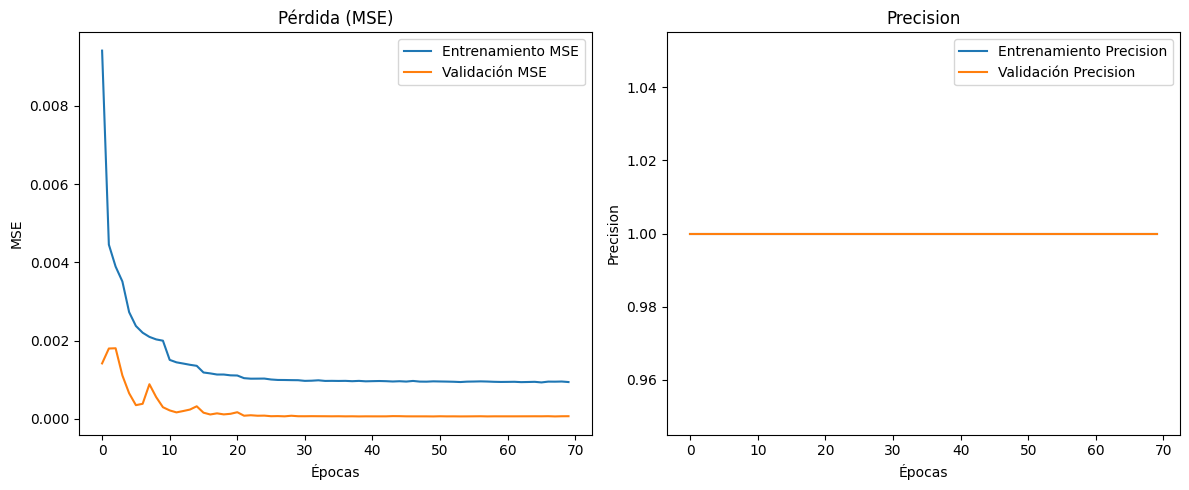

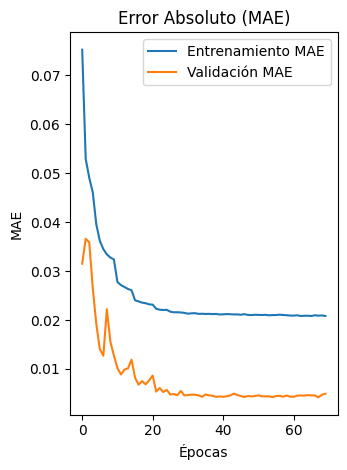

In [50]:
# 9. Visualización de las Métricas de Entrenamiento
def graficar_historial(history):
    plt.figure(figsize=(12, 5))
    
    # Pérdida (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento MSE')
    plt.plot(history.history['val_loss'], label='Validación MSE')
    plt.title('Pérdida (MSE)')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    
    # Error Absoluto (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label='Entrenamiento Precision')
    plt.plot(history.history['val_precision'], label='Validación Precision')
    plt.title('Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Entrenamiento MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validación MAE')
    plt.title('Error Absoluto (MAE)')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


graficar_historial(history)

In [51]:
# 10. Guardar el Modelo y el Escalador

# Guardar el modelo entrenado en formato HDF5
modelo.save('../ia3/model/modelo_trastornos.keras')
print("\nModelo guardado exitosamente en 'modelo_trastornos_cognitivos.keras'")

# Guardar el escalador utilizando joblib
joblib.dump(scaler, '../ia3/scaler/scaler_trastornos_cognitivos_huber_new.joblib')
print("Escalador guardado exitosamente en 'scaler_trastornos_cognitivos.joblib'")


Modelo guardado exitosamente en 'modelo_trastornos_cognitivos.keras'
Escalador guardado exitosamente en 'scaler_trastornos_cognitivos.joblib'
